In [1]:
import os # for pulling up images and annotation
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F

In [2]:
# encoder
import torch
from torch import nn
import torch.nn.functional as F
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=(2,2), padding=1) # assuming input image size is 3 x 64 x 64
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=(2,2), padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=(2,2), padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3,3), stride=(2,2), padding=1)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=(3,3), stride=(2,2), padding=1)
        self.batchnorm5 = nn.BatchNorm2d(512)
        self.fc_mu = nn.Linear(2048, latent_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.batchnorm1(x))
        x = self.conv2(x)
        x = F.relu(self.batchnorm2(x))
        x = self.conv3(x)
        x = F.relu(self.batchnorm3(x))
        x = self.conv4(x)
        x = F.relu(self.batchnorm4(x))
        x = self.conv5(x)
        x = F.relu(self.batchnorm5(x))
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        return mu

In [3]:
# decoder
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 2048)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1)
        self.batchnorm1 = nn.BatchNorm2d(256)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1)
        self.batchnorm4 = nn.BatchNorm2d(32)
        self.deconv5 = nn.ConvTranspose2d(32, 32, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1)
        self.batchnorm5 = nn.BatchNorm2d(32)
        self.conv = nn.Conv2d(32, 3, kernel_size=(3,3), stride=(1,1), padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 512, 2, 2) # reshaping to match the corresponding encoder shape
        x = self.deconv1(x)
        x = F.relu(self.batchnorm1(x))
        x = self.deconv2(x)
        x = F.relu(self.batchnorm2(x))
        x = self.deconv3(x)
        x = F.relu(self.batchnorm3(x))
        x = self.deconv4(x)
        x = F.relu(self.batchnorm4(x))
        x = self.deconv5(x)
        x = F.relu(self.batchnorm5(x))
        x = self.conv(x)
        reconstruction = torch.tanh(x) # Using sigmoid for final layer to output values between 0 and 1
        return reconstruction

In [4]:
# variational autoencoder
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std, std

    def forward(self, x):
        mu = self.encoder(x)
        return self.decoder(mu)

In [42]:
#Load Model
latent_dim = 512

model = VAE(latent_dim)
model.load_state_dict( torch.load('model.pt', map_location=lambda storage, loc: storage))
# model.eval()

<All keys matched successfully>

In [43]:
def count_num_files_in_directory(directory):
    # List the files in the directory
    file_list = os.listdir(directory)

    # Count the number of files, ignoring subdirectories
    file_count = sum(os.path.isfile(os.path.join(directory, f)) for f in file_list)
    return file_count

In [44]:
# Specify the directory you want to count the files for
directory = 'img_align_celeba/img_align_celeba/'

number_of_images_in_celebA = count_num_files_in_directory(directory)
print("num images: ", number_of_images_in_celebA)

num images:  202599


In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CelebADataset(Dataset):
    def __init__(self, directory, split='train', split_ratio = 0.8, num_samples=None, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
        
        # Split data into train and test
#         print(len(self.image_filenames))
        if split == 'train':
            self.image_filenames = self.image_filenames[:int(split_ratio * len(self.image_filenames))]
        elif split == 'test':
            self.image_filenames = self.image_filenames[int(split_ratio * len(self.image_filenames)):]
        
    def __len__(self):
        return 20000
#         return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.image_filenames[idx])
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
        
        return image

# Define a transform to preprocess the images
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor()
])

# Instantiate the dataset
celeba_train_dataset = CelebADataset(directory=directory, split='train', split_ratio = 0.8, transform=transform)
celeba_test_dataset = CelebADataset(directory=directory, split='test', split_ratio = 0.8, transform=transform)

# Create the DataLoader
train_dataloader = DataLoader(celeba_train_dataset, batch_size=36, shuffle=True)
test_dataloader = DataLoader(celeba_test_dataset, batch_size=36, shuffle=False)

In [12]:
img = next(iter(train_dataloader))

torch.Size([36, 3, 64, 64])
torch.Size([36, 3, 64, 64])


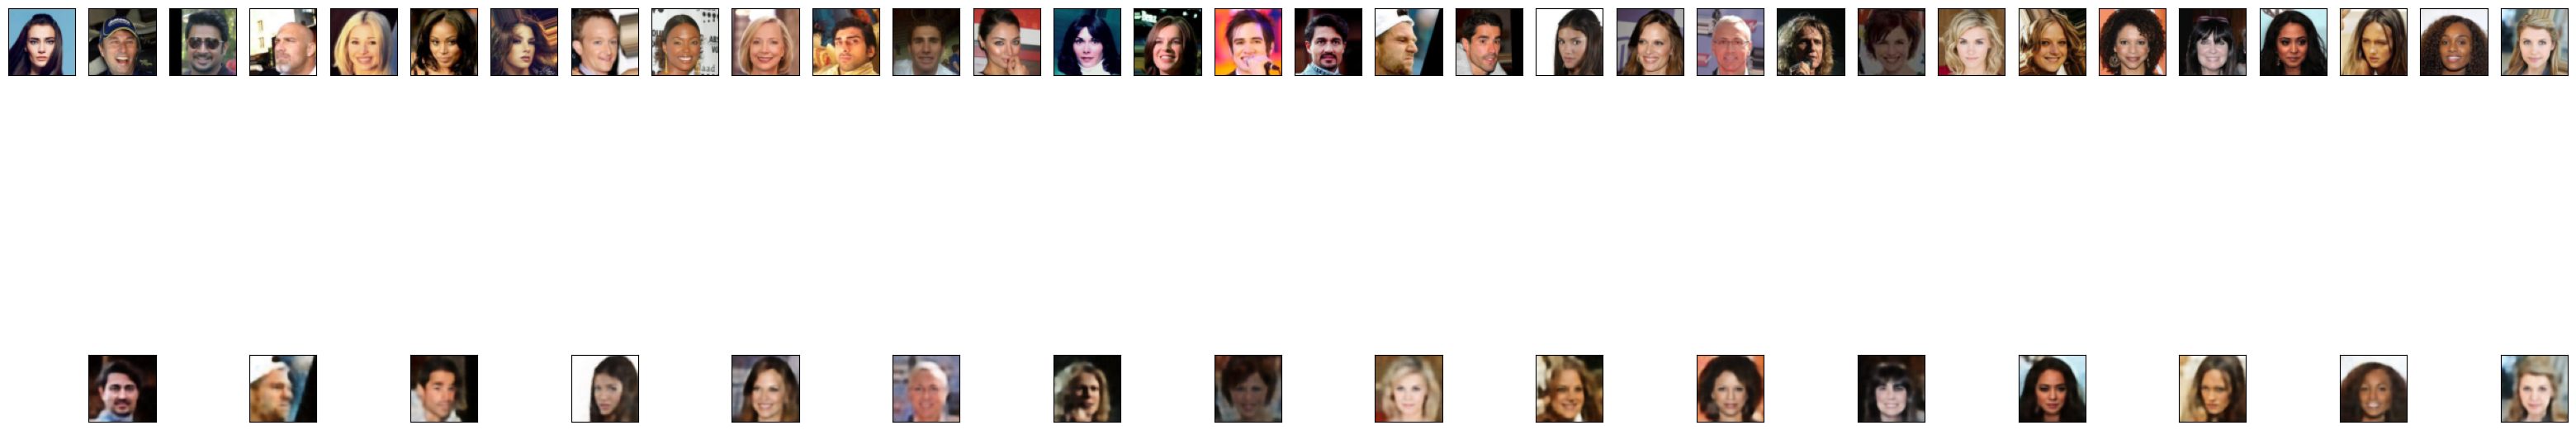

In [45]:
test_examples = img.to('cpu')
reconstruction = model(test_examples)
reconstruction = reconstruction.to('cpu')
reconstruction = reconstruction.to('cpu')
print(img.shape)
print(reconstruction.shape)
with torch.no_grad():
    number = 36
    plt.figure(figsize=(40, 10))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index+1)
        test_examples = test_examples.to('cpu')
        image1 = test_examples[index].permute(1, 2, 0).detach().numpy().clip(0, 1)
        plt.imshow(image1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, 2*(index + 1))
        image2 = reconstruction[index].permute(1, 2, 0).detach().numpy().clip(0, 1)
        plt.imshow(image2)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

In [46]:
test_examples = img.to('cpu')
reconstruction = model(test_examples)
reconstruction = reconstruction.to('cpu')
reconstruction = reconstruction.to('cpu')
print(img.shape)
print(reconstruction.shape)
vutils.save_image(reconstruction.data,
                  os.path.join(
                      "./",
                      f"512ld_AE.png"),
                  normalize=True,
                  nrow=6)
vutils.save_image(test_examples.data,
                  os.path.join(
                      "./",
                      f"IMG_AE.png"),
                  normalize=True,
                  nrow=6)

torch.Size([36, 3, 64, 64])
torch.Size([36, 3, 64, 64])


In [49]:
import numpy as np
mu, sigma = 0.0005, 0.004 # mean and standard deviation
s = np.random.normal(mu, sigma, (36,latent_dim))
t = torch.from_numpy(s)
print(t.shape)

#Get Generated Images
recn = model.decoder(t.float())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
torch.Size([36, 512])
torch.Size([36, 512])


In [51]:
vutils.save_image(recn.data,
                  os.path.join(
                      "./",
                      f".png"),
                  normalize=True,
                  nrow=6)